In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
import tabula as tb
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
import scipy.stats as sp
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PowerTransformer, MaxAbsScaler , OneHotEncoder
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier as knn , KNeighborsRegressor as knr
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.utils.fixes import loguniform
from functions import *
from math import radians
import json
import timeit
from timeit import default_timer as timer
import datetime as dt
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import plotly.graph_objects as go
import shap

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
raw_data = pd.read_csv("DATA/clean_data.csv", index_col = 0)
raw_data = raw_data.reset_index(drop=True)

In [3]:
raw_data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'NumberofBuildings', 'PropertyGFABuilding', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEnergyUse_kBtu',
       'SteamUse_kBtu', 'Electricity_kBtu', 'NaturalGas_kBtu',
       'OtherFuelUse_kBtu', 'GHGEmissions_MetricTonsCO2e',
       'GHGEmissionsIntensity_kgCO2e_ft2'],
      dtype='object')

In [4]:
df_analyse = raw_data.loc[:, ['Electricity_kBtu','BuildingType', 'PrimaryPropertyType', 'Neighborhood']]

In [5]:
df_analyse.describe(include='all')

,Electricity_kBtu,BuildingType,PrimaryPropertyType,Neighborhood
count,3.167000e+03,3167,3167,3167
unique,NaN,8,23,19
top,NaN,NonResidential,Low-Rise Multifamily,DOWNTOWN
freq,NaN,1414,946,543
mean,3.755193e+06,NaN,NaN,NaN
std,1.522212e+07,NaN,NaN,NaN
min,1.058000e+04,NaN,NaN,NaN
25%,6.415160e+05,NaN,NaN,NaN
50%,1.180845e+06,NaN,NaN,NaN
75%,2.867606e+06,NaN,NaN,NaN


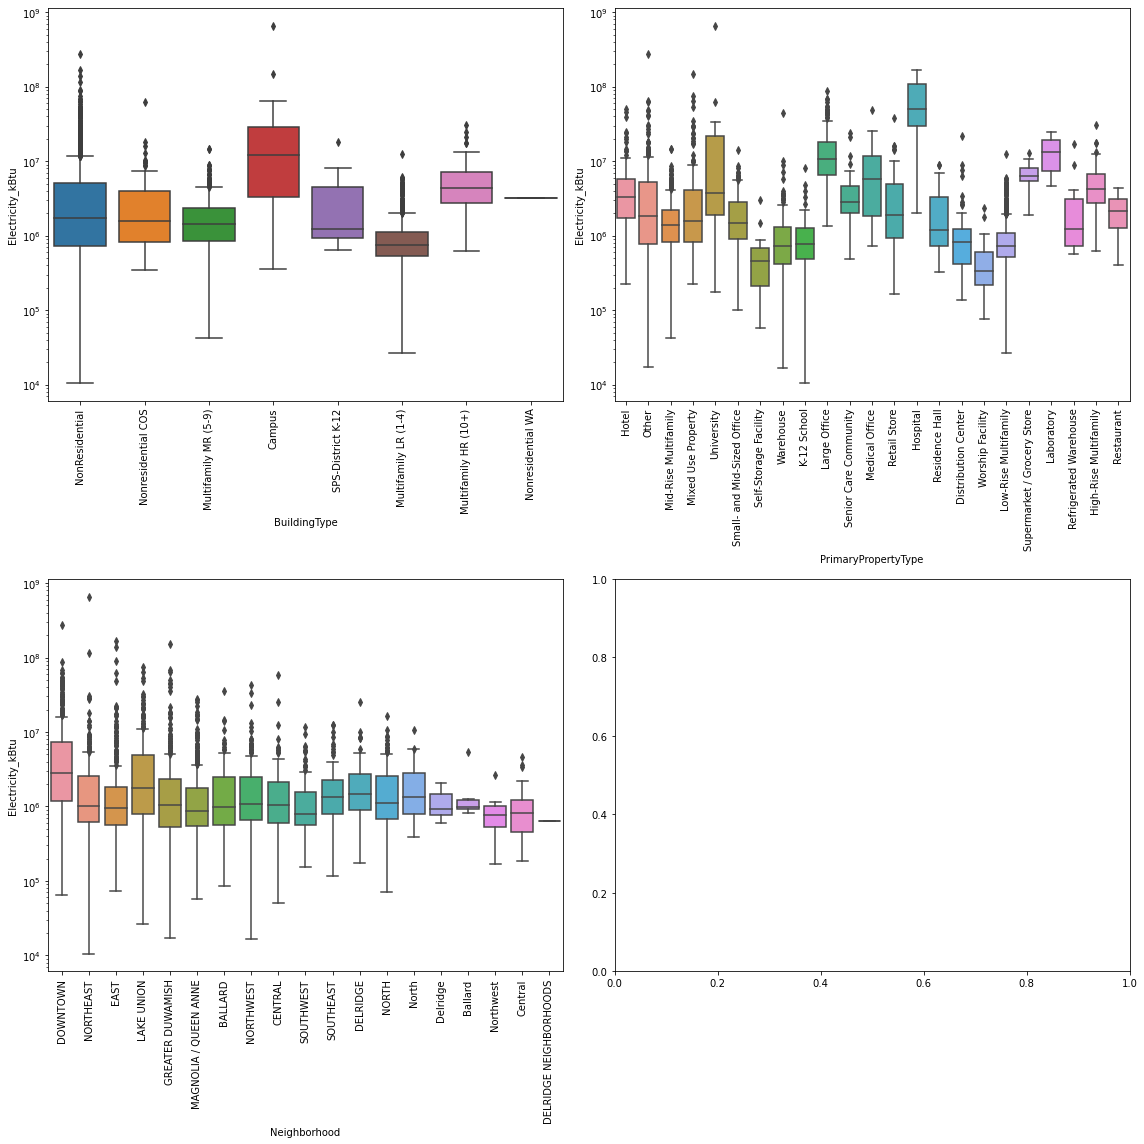

In [6]:
choices = df_analyse.drop('Electricity_kBtu',axis=1).columns

f, axs = plt.subplots(2, 2, figsize = (16, 16))

i=0
choices[i]

for ix, iy in np.ndindex(axs.shape):
    if i == len(choices) :
        break
    else:
        ax1 = sns.boxplot(data = df_analyse, y= "Electricity_kBtu", x=df_analyse[choices[i]],ax=axs[ix, iy])
        ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
        axs[ix, iy].set(yscale="log")
        i+=1
            
plt.tight_layout()

Building_type et PrimaryPropertyType sont les seuls qui semblent pouvoir classer les bâtiment par rapport à leur consommation électrique

In [7]:
df_analyse = raw_data.loc[:, ['Electricity_kBtu','BuildingType', 'PrimaryPropertyType',
       'NumberofBuildings', 'PropertyGFABuilding',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA']]

In [8]:
df_analyse.columns

Index(['Electricity_kBtu', 'BuildingType', 'PrimaryPropertyType',
       'NumberofBuildings', 'PropertyGFABuilding', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

In [9]:
scaler = MaxAbsScaler()

data = df_analyse.loc[:,df_analyse.select_dtypes(include=[np.number]).columns]


for i in data.columns :
    data[i] = scaler.fit_transform(data[i].values.reshape(-1, 1))

data

,Electricity_kBtu,NumberofBuildings,PropertyGFABuilding,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
0,0.006005,0.009009,0.009488,0.009488,0.000000,0.000000
1,0.004935,0.009009,0.009496,0.009000,0.023540,0.010053
2,0.075375,0.009009,0.081478,0.081167,0.000000,0.000000
3,0.004214,0.009009,0.006579,0.006579,0.000000,0.000000
4,0.008170,0.009009,0.012186,0.013245,0.106276,0.000000
...,...,...,...,...,...,...
3162,0.000962,0.009009,0.001959,0.001959,0.000000,0.000000
3163,0.000604,0.009009,0.001717,0.001717,0.000000,0.000000
3164,0.002727,0.009009,0.001412,0.000814,0.008710,0.000000
3165,0.000531,0.009009,0.001513,0.000708,0.010159,0.001053


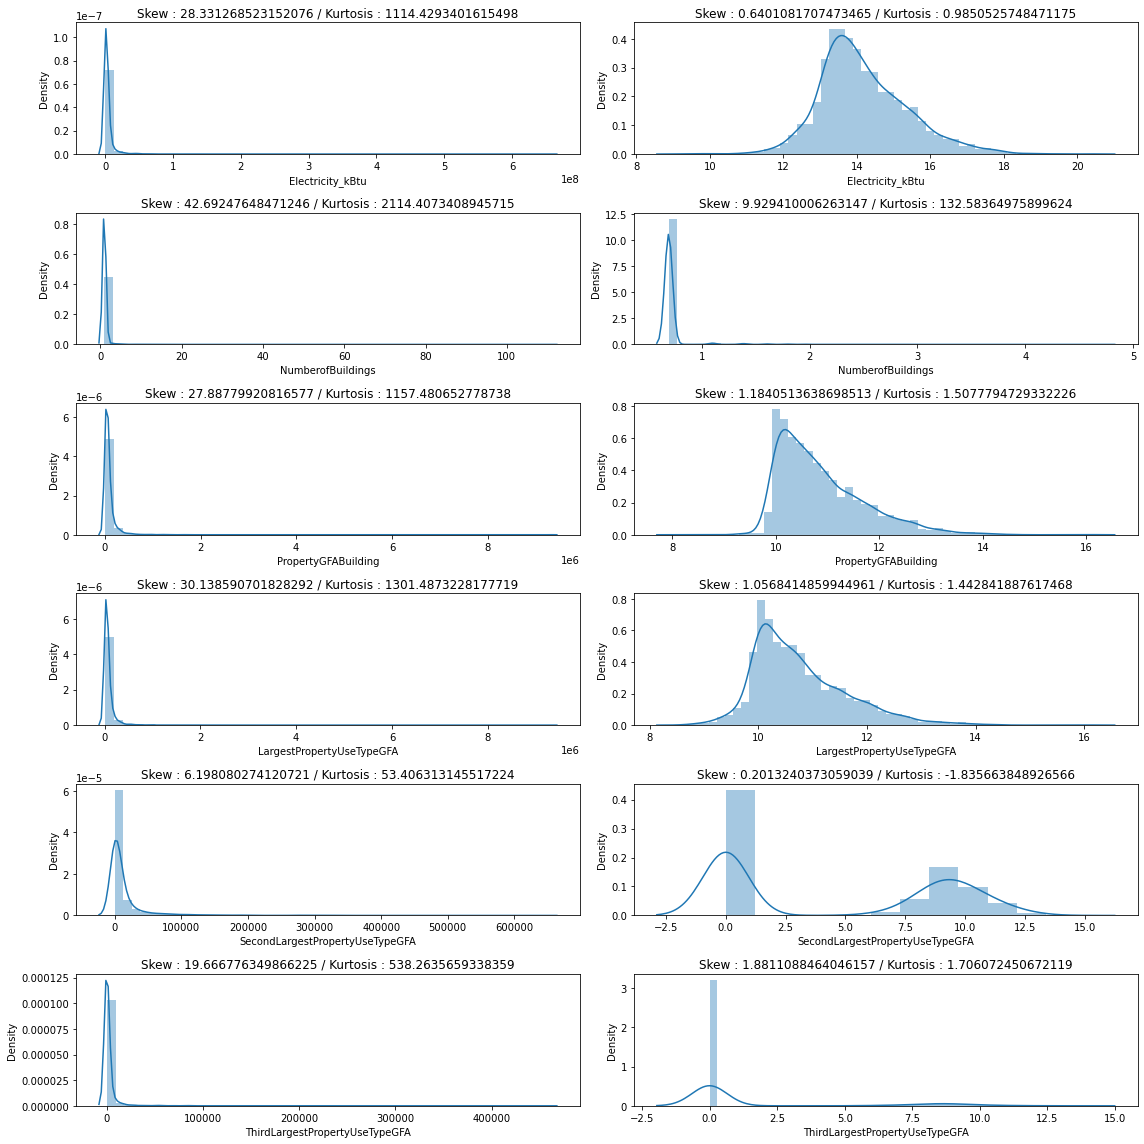

In [10]:
choices = data.columns



f, axs = plt.subplots(6,2, figsize = (16, 16))

i=0
choices[i]

for ix,iy in np.ndindex(axs.shape):
    if i == len(choices) :
        break
    else:
        if iy / 2 == 0 :
            k = df_analyse[choices[i]].kurtosis()
            sk = df_analyse[choices[i]].skew()
            ax1 = sns.distplot(df_analyse[choices[i]],ax=axs[ix,iy])
            ax1.set_title("Skew : " + str(sk) + " / Kurtosis : " + str(k))

        else :
            
            k = np.log(df_analyse[choices[i]]+1).kurtosis()
            sk = np.log(df_analyse[choices[i]]+1).skew()
            ax1 = sns.distplot(np.log(df_analyse[choices[i]]+1),ax=axs[ix,iy])
            ax1.set_title("Skew : " + str(sk) + " / Kurtosis : " + str(k))
            
            i+=1
            



plt.tight_layout()

In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_analyse.loc[:,["BuildingType", "PrimaryPropertyType"]])
one = enc.transform(df_analyse.loc[:,["BuildingType", "PrimaryPropertyType"]]).toarray()

In [12]:
one.shape

(3167, 31)

In [13]:
col = enc.get_feature_names()

In [14]:
df_one = pd.DataFrame(data = one, columns = col)
del one, col

In [15]:
df_analyse = pd.concat([df_analyse, df_one] ,axis = 1)
df_analyse = df_analyse.drop(['BuildingType', 'PrimaryPropertyType'],axis = 1)
del df_one

In [16]:
df_analyse.describe()

,Electricity_kBtu,NumberofBuildings,PropertyGFABuilding,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,x0_Campus,x0_Multifamily HR (10+),x0_Multifamily LR (1-4),x0_Multifamily MR (5-9),x0_NonResidential,x0_Nonresidential COS,x0_Nonresidential WA,x0_SPS-District K-12,x1_Distribution Center,x1_High-Rise Multifamily,x1_Hospital,x1_Hotel,x1_K-12 School,x1_Laboratory,x1_Large Office,x1_Low-Rise Multifamily,x1_Medical Office,x1_Mid-Rise Multifamily,x1_Mixed Use Property,x1_Other,x1_Refrigerated Warehouse,x1_Residence Hall,x1_Restaurant,x1_Retail Store,x1_Self-Storage Facility,x1_Senior Care Community,x1_Small- and Mid-Sized Office,x1_Supermarket / Grocery Store,x1_University,x1_Warehouse,x1_Worship Facility
count,3.167000e+03,3167.000000,3.167000e+03,3.167000e+03,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000
mean,3.755193e+06,1.138617,8.638683e+04,7.855357e+04,14320.106504,2147.673634,0.007578,0.034102,0.307547,0.178087,0.446479,0.022734,0.000316,0.003158,0.016735,0.032523,0.003158,0.023997,0.015788,0.003158,0.051153,0.298705,0.012314,0.172719,0.041364,0.075466,0.003789,0.007262,0.003473,0.026524,0.008841,0.013578,0.089043,0.012314,0.007894,0.058415,0.021787
std,1.522212e+07,2.163131,2.114531e+05,2.054021e+05,39783.954252,13491.171144,0.086736,0.181519,0.461551,0.382646,0.497206,0.149079,0.017770,0.056112,0.128297,0.177412,0.056112,0.153065,0.124673,0.056112,0.220344,0.457763,0.110303,0.378064,0.199162,0.264183,0.061448,0.084923,0.058842,0.160711,0.093626,0.115747,0.284851,0.110303,0.088510,0.234563,0.146011
min,1.058000e+04,1.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.415160e+05,1.000000,2.749700e+04,2.494350e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.180845e+06,1.000000,4.240100e+04,3.885000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.867606e+06,1.000000,8.399950e+04,7.506400e+04,11097.500000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.570744e+08,111.000000,9.320156e+06,9.320156e+06,639931.000000,459748.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
y = np.log(df_analyse['Electricity_kBtu']+1)
features = df_analyse.drop(['Electricity_kBtu'],axis = 1)
features.iloc[:,:5] = np.log(features.iloc[:,:5]+1)
features_name = features.columns

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.33, random_state = 42)

In [19]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_x.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
X_test = scaler_x.transform(X_test)
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

In [20]:
X_test_t = pd.DataFrame(X_test, columns = features_name)
X_train_t = pd.DataFrame(X_train, columns = features_name)

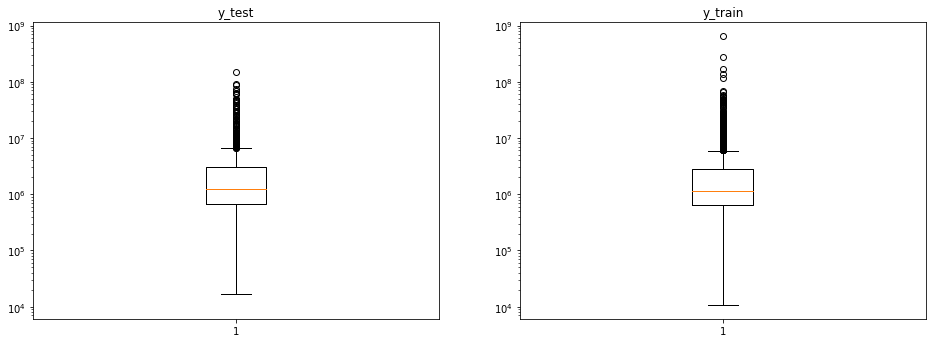

In [21]:
a = [(np.exp(scaler_y.inverse_transform(y_test))-1).reshape(1,-1).tolist(), (np.exp(scaler_y.inverse_transform(y_train))-1).reshape(1,-1).tolist()]

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, sharey=ax1)

ax1.boxplot(a[0], meanline = True)
ax1.set_title('y_test')
ax2.boxplot(a[1], meanline = True)
ax2.set_title('y_train')
ax1.set(yscale="log")
ax2.set(yscale="log")
plt.show()

In [22]:
print('Mean y_test : ', round(scaler_y.inverse_transform(y_test).mean(),3))
print('Mean y_train : ', round(scaler_y.inverse_transform(y_train).mean(), 3))

Mean y_test :  14.237
Mean y_train :  14.145


## RANDOMFOREST

In [23]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid


random_grid = {'ccp_alpha': [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [24]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model 
start = timer()
rf_random.fit(X_train, y_train)
end = timer()

print ("The time of execution of above program is : ", dt.timedelta(seconds=end-start))
l_time_model = {}
l_time_model['RandomForestRegressor'] = dt.timedelta(seconds=end-start).total_seconds()

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
The time of execution of above program is :  0:14:31.940962


In [25]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [26]:
rf_random.best_params_

{'n_estimators': 336,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'ccp_alpha': 0.0001,
 'bootstrap': True}

In [27]:
rf_random.best_score_

0.7397320423026533

In [28]:
best_random = rf_random.best_estimator_
random_accuracy_test = rf_random.score(X_test, y_test)
random_accuracy_train = rf_random.score(X_train, y_train)

In [29]:
print("Score train : " + str(random_accuracy_train))
print("Score test : " + str(random_accuracy_test))

Score train : 0.8627823117429201
Score test : 0.7688798475323226


In [30]:
# Make predictions and determine the error
predictions = rf_random.predict(X_train)
errors = abs(y_train - predictions)
# Display the performance metrics
print("-- Train score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((y_train - predictions) / y_train))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(y_train, predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(y_train, predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Make predictions and determine the error
predictions = rf_random.predict(X_test)
errors = abs(y_test - predictions)
# Display the performance metrics
print("-- Test score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((y_test - predictions) / y_test))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(y_test, predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(y_test, predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')


perf_model = {}
perf_model['RandomForestRegressor'] = mape

-- Train score --
Mean Absolute Deviation: 1.02
MAPE: 4.91 %.
MSE :  0.14
RMSE :  0.37
Accuracy: 95.09 %.
-- Test score --
Mean Absolute Deviation: 1.05
MAPE: 3.8 %.
MSE :  0.25
RMSE :  0.5
Accuracy: 96.2 %.


100%|===================| 2119/2121 [01:28<00:00]        

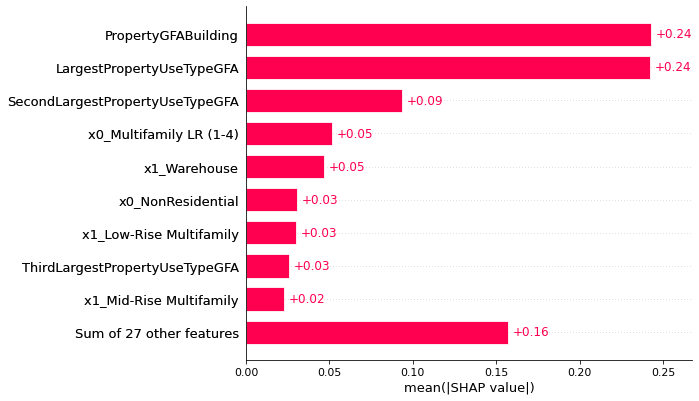

In [31]:
explainer = shap.TreeExplainer(rf_random.best_estimator_, X_train_t)
shap_values = explainer(X_train_t)

shap.plots.bar(shap_values)

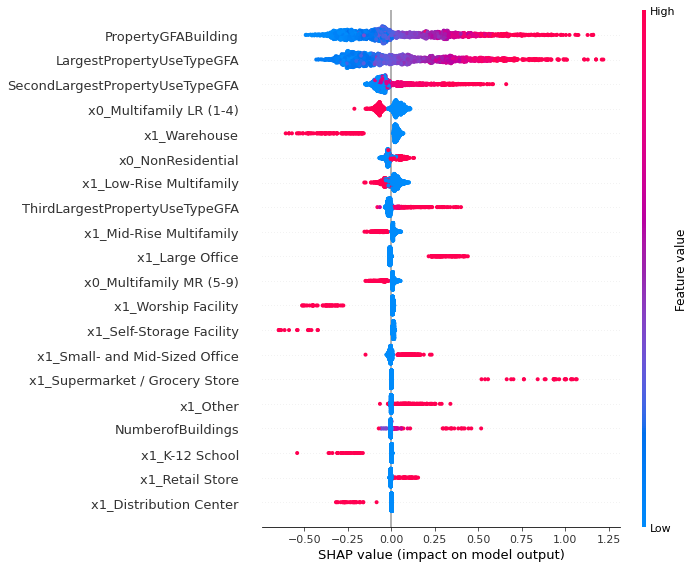

In [32]:
shap.summary_plot(shap_values, feature_names=features_name)

In [33]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(features_name, round(importance, 2)) for features_name, importance in zip(features_name, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: PropertyGFABuilding  Importance: 0.3
Variable: LargestPropertyUseTypeGFA Importance: 0.28
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.11
Variable: x1_Large Office      Importance: 0.05
Variable: ThirdLargestPropertyUseTypeGFA Importance: 0.03
Variable: x1_Low-Rise Multifamily Importance: 0.03
Variable: x1_Supermarket / Grocery Store Importance: 0.03
Variable: NumberofBuildings    Importance: 0.02
Variable: x0_Multifamily LR (1-4) Importance: 0.02
Variable: x1_Warehouse         Importance: 0.02
Variable: x0_Multifamily MR (5-9) Importance: 0.01
Variable: x0_NonResidential    Importance: 0.01
Variable: x1_Hospital          Importance: 0.01
Variable: x1_K-12 School       Importance: 0.01
Variable: x1_Mid-Rise Multifamily Importance: 0.01
Variable: x1_Other             Importance: 0.01
Variable: x1_Self-Storage Facility Importance: 0.01
Variable: x1_Small- and Mid-Sized Office Importance: 0.01
Variable: x1_Worship Facility  Importance: 0.01
Variable: x0_Campus        

In [34]:
rf_df = pd.DataFrame(data = predictions)
rf_df['True_values'] = y_test
rf_df.columns = ['predictions', 'True_values']
rf_df['Residus'] = rf_df['predictions'] - rf_df['True_values']

In [35]:
rf_df = rf_df.sort_values('predictions')
rf_df = rf_df.reset_index(drop=True)

No handles with labels found to put in legend.


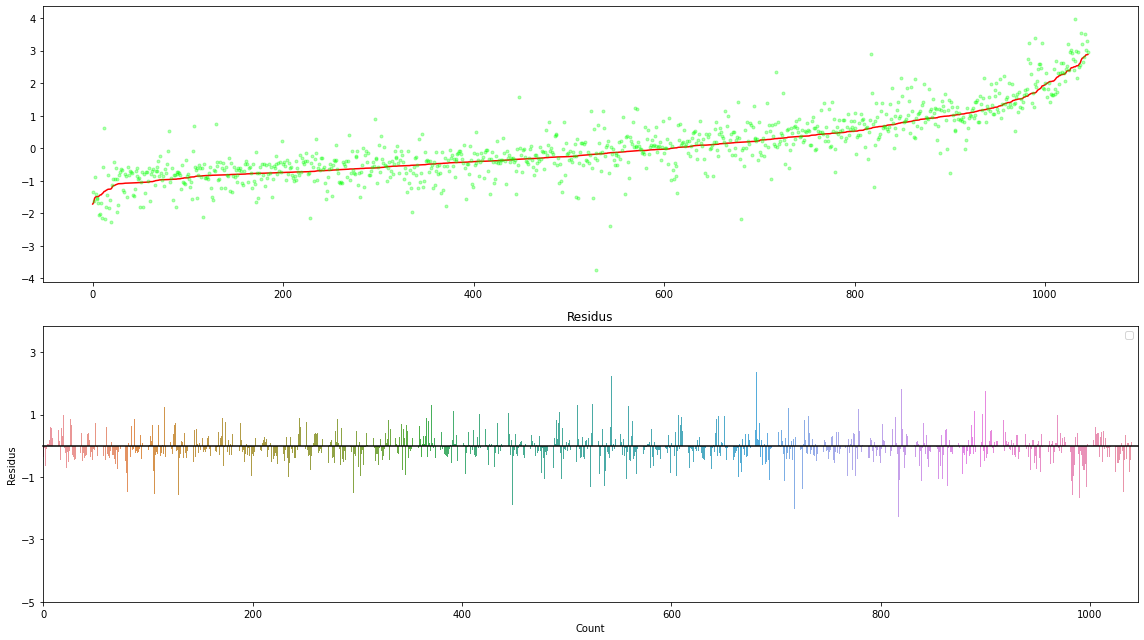

In [36]:
figs, axs = plt.subplots(2,1,figsize=(16,9))
axs[0].plot(rf_df.index.to_list(), rf_df['predictions'].values, c='red', label='Prediction')
axs[0].plot(rf_df.index.to_list(), rf_df['True_values'].values, linestyle = 'none', marker= '.', c='lime',alpha=0.3, label='True_value')


sns.barplot(x=rf_df.index.to_list(), y=rf_df['Residus'], ax=axs[1])
axs[1].axhline(0, color="k", clip_on=False)
axs[1].set(xlabel='Count', ylabel='Residus')
axs[1].set_title("Residus")
axs[1].set_xticks(np.arange(min(rf_df.index.to_list()), max(rf_df.index.to_list())+1, 200))
axs[1].set_yticks(np.arange(round(-max(rf_df['Residus']),0)-1, round(max(rf_df['Residus']),0)+1, 2))

plt.legend()
plt.tight_layout()

## ELASTICNET

In [37]:
random_grid = {'alpha': np.logspace(-5, 1, 60),
               'l1_ratio':[.1, .5, .7, .9, .95, .99, 1],
               'selection':['cyclic', 'random']}

In [38]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
eln = ElasticNet(fit_intercept=False)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
eln_random = RandomizedSearchCV(estimator = eln, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
start = timer()
eln_random.fit(X_train, y_train)
end = timer()

print ("The time of execution of above program is : ", dt.timedelta(seconds=end-start))
l_time_model['ElasticNet'] = dt.timedelta(seconds=end-start).total_seconds()

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
The time of execution of above program is :  0:00:09.382418


In [39]:
ElasticNet().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'l1_ratio', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [40]:
eln_random.best_params_

{'selection': 'cyclic', 'l1_ratio': 0.1, 'alpha': 0.011242100350620874}

In [41]:
eln_random.best_score_

0.7545229202106722

In [42]:
best_random = eln_random.best_estimator_
random_accuracy_test = eln_random.score(X_test, y_test)
random_accuracy_train = eln_random.score(X_train, y_train)

In [43]:
print("Score train : " + str(random_accuracy_train))
print("Score test : " + str(random_accuracy_test))

Score train : 0.7653623961353321
Score test : 0.7754514256584366


In [44]:
# Make predictions and determine the error
predictions = eln_random.predict(X_train)
errors = abs(y_train - predictions)
# Display the performance metrics
print("-- Train score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((y_train - predictions) / y_train))
print('MAPE:', round(mape, 2), '%.')
rmse = mean_squared_error(y_train, predictions, squared = False)
print('RMSE : ', round(rmse*100, 2), '%.')
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Make predictions and determine the error
predictions = eln_random.predict(X_test)
errors = abs(y_test - predictions)
# Display the performance metrics
print("-- Test score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((y_test - predictions) / y_test))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(y_test, predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(y_test, predictions, squared = False)
print('RMSE : ', round(rmse*100, 2), '%.')
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

perf_model['ElasticNet'] = mape

-- Train score --
Mean Absolute Deviation: 1.02
MAPE: 4.89 %.
RMSE :  48.44 %.
Accuracy: 95.11 %.
-- Test score --
Mean Absolute Deviation: 1.06
MAPE: 3.83 %.
MSE :  0.24
RMSE :  48.96 %.
Accuracy: 96.17 %.


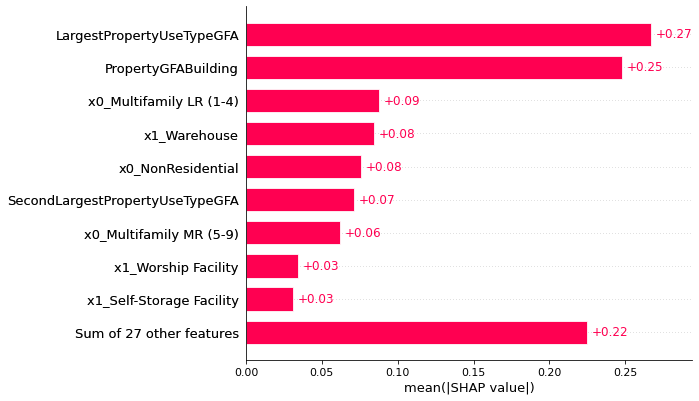

In [45]:
explainer = shap.Explainer(eln_random.best_estimator_, X_train_t)
shap_values = explainer(X_train_t)

shap.plots.bar(shap_values)

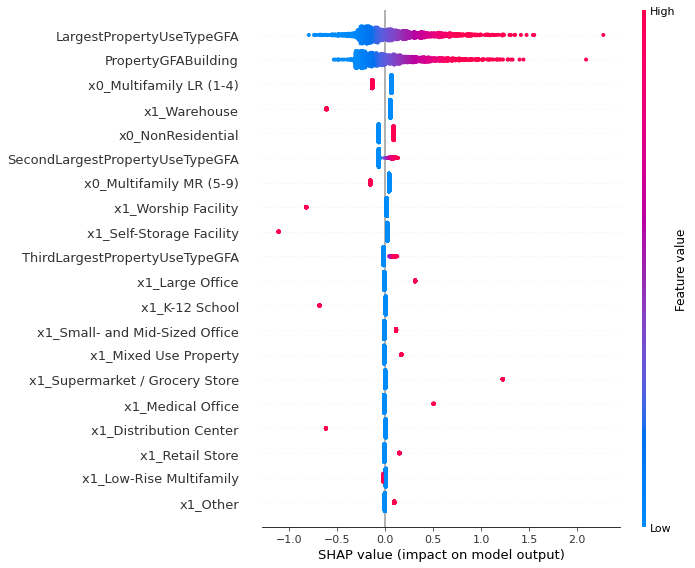

In [46]:
shap.summary_plot(shap_values, feature_names=features_name)

In [47]:
eln_df = pd.DataFrame(data = predictions)
eln_df['True_values'] = y_test
eln_df.columns = ['predictions', 'True_values']
eln_df['Residus'] = eln_df['predictions'] - eln_df['True_values']

In [48]:
eln_df = eln_df.sort_values('predictions')
eln_df = eln_df.reset_index(drop=True)

No handles with labels found to put in legend.


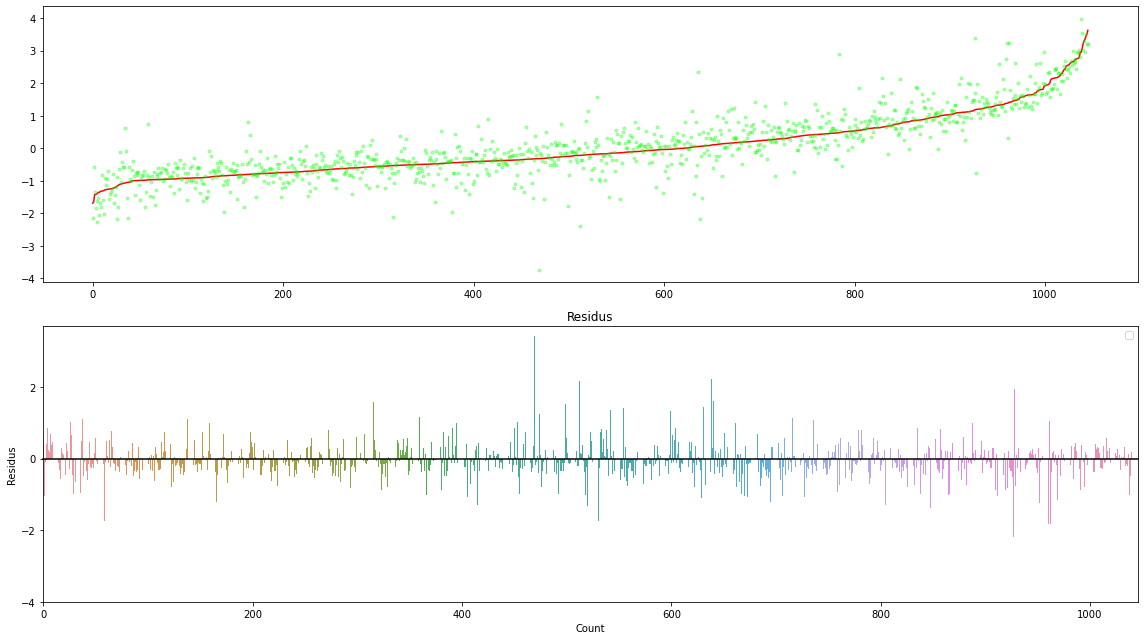

In [49]:
figs, axs = plt.subplots(2,1,figsize=(16,9))
axs[0].plot(eln_df.index.to_list(), eln_df['predictions'].values, c='red', label='Prediction')
axs[0].plot(eln_df.index.to_list(), eln_df['True_values'].values, linestyle = 'none', marker= '.', c='lime',alpha=0.3, label='True_value')


sns.barplot(x=eln_df.index.to_list(), y=eln_df['Residus'], ax=axs[1])
axs[1].axhline(0, color="k", clip_on=False)
axs[1].set(xlabel='Count', ylabel='Residus')
axs[1].set_title("Residus")
axs[1].set_xticks(np.arange(min(eln_df.index.to_list()), max(eln_df.index.to_list())+1, 200))
axs[1].set_yticks(np.arange(round(-max(eln_df['Residus']),0)-1, round(max(eln_df['Residus']),0)+1, 2))

plt.legend()
plt.tight_layout()

## ADABOOST

In [50]:
random_grid = {'loss':['linear', 'square', 'exponential'],
               'n_estimators':np.arange(10,200,10),
              'learning_rate': np.arange(-5,15,0.01)}

In [51]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
ada = AdaBoostRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
ada_random = RandomizedSearchCV(estimator = ada, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
start = timer()
ada_random.fit(X_train, y_train)
end = timer()

print ("The time of execution of above program is : ", dt.timedelta(seconds=end-start))
l_time_model['AdaBoostRegressor'] = dt.timedelta(seconds=end-start).total_seconds()

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
The time of execution of above program is :  0:01:08.297622


In [52]:
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [53]:
ada_random.best_params_

{'n_estimators': 30,
 'loss': 'exponential',
 'learning_rate': 0.34999999999988596}

In [54]:
ada_random.best_score_

0.6131094643673638

In [55]:
best_random = ada_random.best_estimator_
random_accuracy_test = ada_random.score(X_test, y_test)
random_accuracy_train = ada_random.score(X_train, y_train)

In [56]:
print("Score train : " + str(random_accuracy_train))
print("Score test : " + str(random_accuracy_test))

Score train : 0.6583470748323645
Score test : 0.6423740040423352


In [57]:
# Make predictions and determine the error
predictions = ada_random.predict(X_train)
errors = abs(y_train - predictions)
# Display the performance metrics
print("-- Train score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((y_train - predictions) / y_train))
print('MAPE:', round(mape, 2), '%.')
rmse = mean_squared_error(y_train, predictions, squared = False)
print('RMSE : ', round(rmse*100, 2), '%.')
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Make predictions and determine the error
predictions = ada_random.predict(X_test)
errors = abs(y_test - predictions)
# Display the performance metrics
print("-- Test score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((y_test - predictions) / y_test))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(y_test, predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(y_test, predictions, squared = False)
print('RMSE : ', round(rmse*100, 2), '%.')
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')


perf_model['AdaBoost'] = mape

-- Train score --
Mean Absolute Deviation: 0.97
MAPE: 4.35 %.
RMSE :  58.45 %.
Accuracy: 95.65 %.
-- Test score --
Mean Absolute Deviation: 1.0
MAPE: 3.4 %.
MSE :  0.38
RMSE :  61.79 %.
Accuracy: 96.6 %.


In [58]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(features_name, round(importance, 2)) for features_name, importance in zip(features_name, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: LargestPropertyUseTypeGFA Importance: 0.43
Variable: PropertyGFABuilding  Importance: 0.34
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.07
Variable: x1_Warehouse         Importance: 0.05
Variable: x1_K-12 School       Importance: 0.04
Variable: x1_Other             Importance: 0.03
Variable: x1_Supermarket / Grocery Store Importance: 0.02
Variable: ThirdLargestPropertyUseTypeGFA Importance: 0.01
Variable: NumberofBuildings    Importance: 0.0
Variable: x0_Campus            Importance: 0.0
Variable: x0_Multifamily HR (10+) Importance: 0.0
Variable: x0_Multifamily LR (1-4) Importance: 0.0
Variable: x0_Multifamily MR (5-9) Importance: 0.0
Variable: x0_NonResidential    Importance: 0.0
Variable: x0_Nonresidential COS Importance: 0.0
Variable: x0_Nonresidential WA Importance: 0.0
Variable: x0_SPS-District K-12 Importance: 0.0
Variable: x1_Distribution Center Importance: 0.0
Variable: x1_High-Rise Multifamily Importance: 0.0
Variable: x1_Hospital          Importance: 0.0


In [59]:
ada_df = pd.DataFrame(data = predictions)
ada_df['True_values'] = y_test
ada_df.columns = ['predictions', 'True_values']
ada_df['Residus'] = ada_df['predictions'] - ada_df['True_values']

In [60]:
ada_df = ada_df.sort_values('predictions')
ada_df = ada_df.reset_index(drop=True)

No handles with labels found to put in legend.


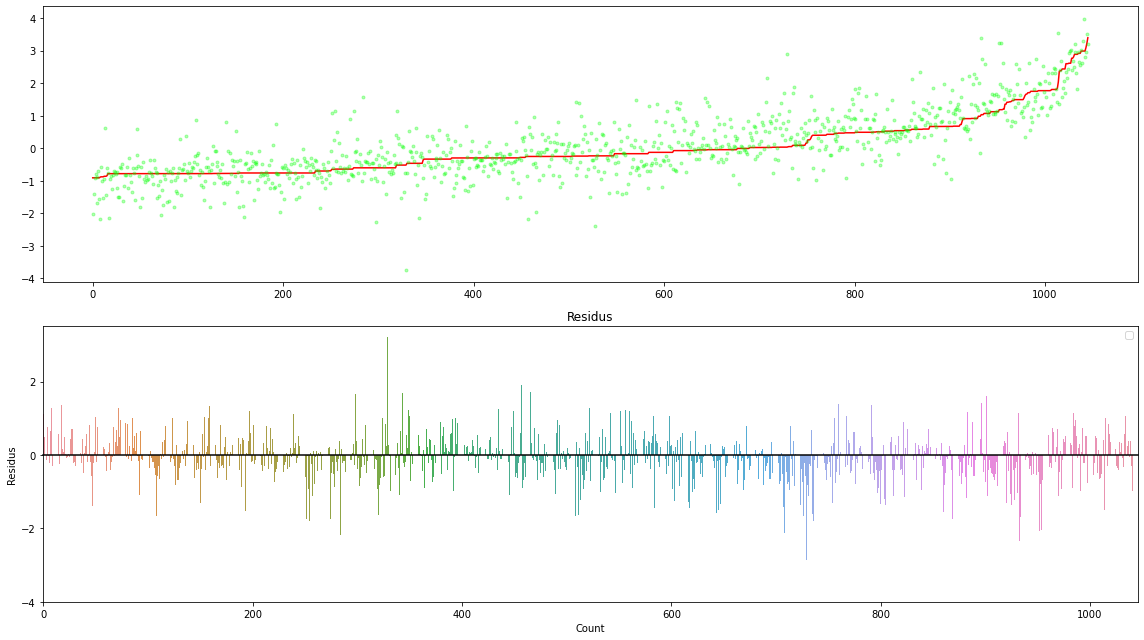

In [61]:
figs, axs = plt.subplots(2,1,figsize=(16,9))
axs[0].plot(ada_df.index.to_list(), ada_df['predictions'].values, c='red', label='Prediction')
axs[0].plot(ada_df.index.to_list(), ada_df['True_values'].values, linestyle = 'none', marker= '.', c='lime',alpha=0.3, label='True_value')


sns.barplot(x=ada_df.index.to_list(), y=ada_df['Residus'], ax=axs[1])
axs[1].axhline(0, color="k", clip_on=False)
axs[1].set(xlabel='Count', ylabel='Residus')
axs[1].set_title("Residus")
axs[1].set_xticks(np.arange(min(ada_df.index.to_list()), max(ada_df.index.to_list())+1, 200))
axs[1].set_yticks(np.arange(round(-max(ada_df['Residus']),0)-1, round(max(ada_df['Residus']),0)+1, 2))

plt.legend()
plt.tight_layout()

## XGBOOST REGRESSOR

In [62]:
xgb1 = XGBRegressor(booster = 'gbtree')
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.01,.02,.03, 0.05, .07], #so called `eta` value
              'max_depth': [2,3,4,5],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [400]}

xgb_grid = RandomizedSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        verbose=2,
                        n_iter = 200,
                        n_jobs = -1)

In [63]:
start = timer()
xgb_grid.fit(X_train, y_train)
end = timer()

print ("The time of execution of above program is : ", dt.timedelta(seconds=end-start))
l_time_model['XgBoost_Regressor'] = dt.timedelta(seconds=end-start).total_seconds()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The time of execution of above program is :  0:02:12.791553


In [64]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.7452723437030692
{'subsample': 0.7, 'objective': 'reg:squarederror', 'nthread': 4, 'n_estimators': 400, 'min_child_weight': 4, 'max_depth': 2, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [65]:
best_random = xgb_grid.best_estimator_
random_accuracy_test = xgb_grid.score(X_test, y_test)
random_accuracy_train = xgb_grid.score(X_train, y_train)

In [66]:
print("Score train : " + str(random_accuracy_train))
print("Score test : " + str(random_accuracy_test))

Score train : 0.789651677933116
Score test : 0.7813449962217601


In [67]:
# Make predictions and determine the error

predictions = xgb_grid.predict(X_train)
errors = abs(y_train - predictions)
# Display the performance metrics
print("-- Train score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((y_train - predictions) / y_train))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(y_train, predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(y_train, predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

# Make predictions and determine the error
predictions = xgb_grid.predict(X_test)
errors = abs(y_test - predictions)
# Display the performance metrics
print("-- Test score --")
print('Mean Absolute Deviation:', round(np.mean(errors), 2))
mape = np.mean(abs((y_test - predictions) / y_test))
print('MAPE:', round(mape, 2), '%.')
mse = mean_squared_error(y_test, predictions, squared = True)
print('MSE : ', round(mse, 2))
rmse = mean_squared_error(y_test, predictions, squared = False)
print('RMSE : ', round(rmse, 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

perf_model['XGBoost Regressor'] = mape

-- Train score --
Mean Absolute Deviation: 1.02
MAPE: 4.91 %.
MSE :  0.21
RMSE :  0.46
Accuracy: 95.09 %.
-- Test score --
Mean Absolute Deviation: 1.06
MAPE: 3.85 %.
MSE :  0.23
RMSE :  0.48
Accuracy: 96.15 %.


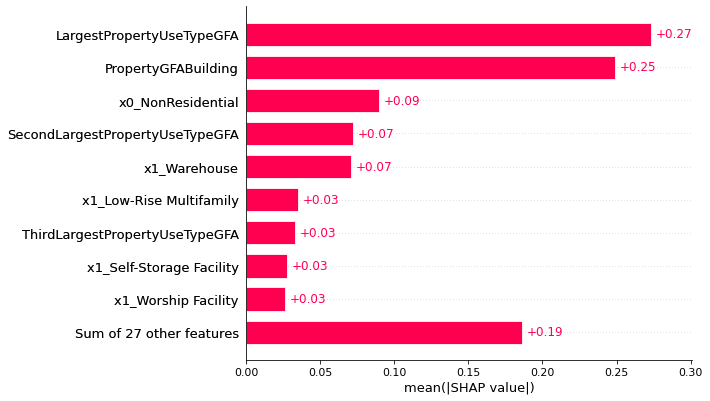

In [68]:
explainer = shap.TreeExplainer(xgb_grid.best_estimator_, X_train_t)
shap_values = explainer(X_train_t)

shap.plots.bar(shap_values)

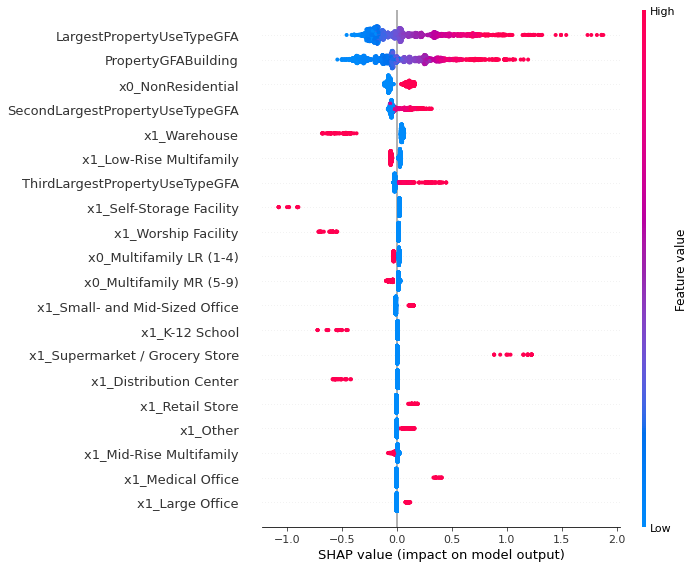

In [69]:
shap.summary_plot(shap_values, feature_names=features_name)

In [70]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(features_name, round(importance, 2)) for features_name, importance in zip(features_name, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: LargestPropertyUseTypeGFA Importance: 0.17000000178813934
Variable: PropertyGFABuilding  Importance: 0.12999999523162842
Variable: x1_Low-Rise Multifamily Importance: 0.07000000029802322
Variable: x1_Supermarket / Grocery Store Importance: 0.05999999865889549
Variable: x0_NonResidential    Importance: 0.05000000074505806
Variable: SecondLargestPropertyUseTypeGFA Importance: 0.03999999910593033
Variable: x1_Large Office      Importance: 0.03999999910593033
Variable: x1_Warehouse         Importance: 0.03999999910593033
Variable: x0_Multifamily LR (1-4) Importance: 0.029999999329447746
Variable: x0_Multifamily MR (5-9) Importance: 0.029999999329447746
Variable: x1_Other             Importance: 0.029999999329447746
Variable: x1_Self-Storage Facility Importance: 0.029999999329447746
Variable: x1_Small- and Mid-Sized Office Importance: 0.029999999329447746
Variable: x1_Worship Facility  Importance: 0.029999999329447746
Variable: NumberofBuildings    Importance: 0.019999999552965164

In [71]:
xgb_df = pd.DataFrame(data = (scaler_y.inverse_transform(predictions)))
xgb_df['True_values'] = (scaler_y.inverse_transform(y_test))
xgb_df.columns = ['predictions', 'True_values']
xgb_df['Residus'] = xgb_df['predictions'] - xgb_df['True_values']

In [72]:
xgb_df = xgb_df.sort_values('predictions')
xgb_df = xgb_df.reset_index(drop=True)

No handles with labels found to put in legend.


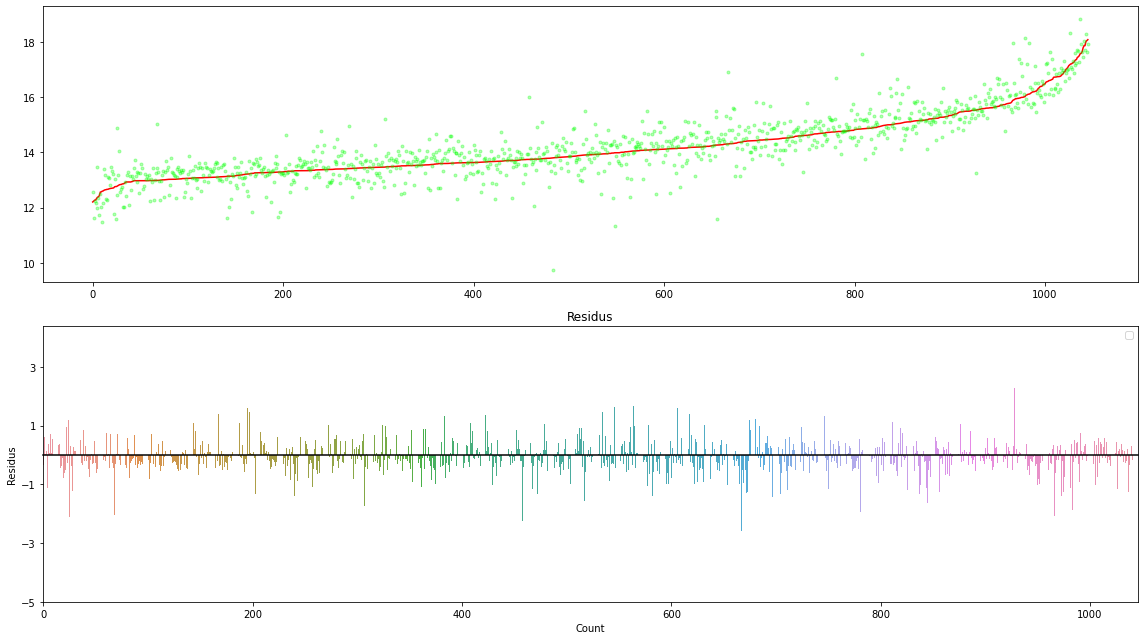

In [73]:
figs, axs = plt.subplots(2,1,figsize=(16,9))
axs[0].plot(xgb_df.index.to_list(), xgb_df['predictions'].values, c='red', label='Prediction')
axs[0].plot(xgb_df.index.to_list(), xgb_df['True_values'].values, linestyle = 'none', marker= '.', c='lime',alpha=0.3, label='True_value')


sns.barplot(x=xgb_df.index.to_list(), y=xgb_df['Residus'], ax=axs[1])
axs[1].axhline(0, color="k", clip_on=False)
axs[1].set(xlabel='Count', ylabel='Residus')
axs[1].set_title("Residus")
axs[1].set_xticks(np.arange(min(xgb_df.index.to_list()), max(xgb_df.index.to_list())+1, 200))
axs[1].set_yticks(np.arange(round(-max(xgb_df['Residus']),0)-1, round(max(xgb_df['Residus']),0)+1, 2))

plt.legend()
plt.tight_layout()

In [74]:
resid = xgb_df['Residus']

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(resid, scaler_x.inverse_transform(X_test))

lzip(names, test)

[('Lagrange multiplier statistic', 23.113816894478358),
 ('p-value', 0.9383717336041264),
 ('f-value', 0.6929644077753788),
 ('f p-value', 0.9041227712765517)]

In [75]:
df_model = pd.DataFrame.from_dict(l_time_model, orient='index',
                       columns=["time_seconds"])
pf_model = pd.DataFrame.from_dict(perf_model, orient='index',
                       columns=["MAPE_value"])

In [76]:
df_model = df_model.reset_index()
pf_model = pf_model.reset_index()

In [77]:
df_model = df_model.rename(columns={"index":"RegressionModel"})
pf_model = pf_model.rename(columns={"index":"RegressionModel"})

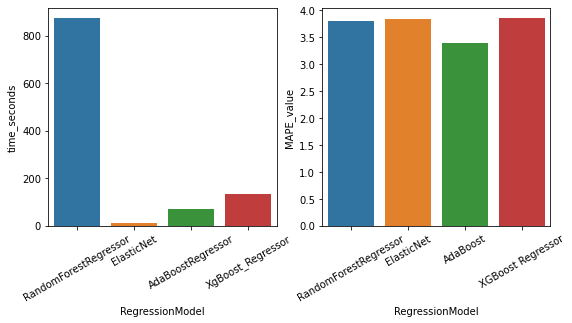

In [78]:
figs, axs = plt.subplots(1, 2,figsize =(9,4))
ax1 = sns.barplot(data=df_model, x="RegressionModel", y="time_seconds", ax = axs[0])
ax2 = sns.barplot(data=pf_model, x="RegressionModel", y="MAPE_value", ax = axs[1])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)

plt.show()

In [79]:
predictions = pd.Series(np.exp(scaler_y.inverse_transform(ada_random.predict(scaler_x.transform(features))))-1, name = 'Elec_pred')
predictions.to_csv("DATA/Predictions/elec_pred.csv")